<img src='pics/otus.png'>

In [1]:
from __future__ import print_function
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings("ignore")


## 0. Выберите любой датасет, связанный с медицинской тематикой.

Выбран датасет https://www.kaggle.com/ruslankl/mice-protein-expression

# 1. Провести EDA
Просмотреть структуру данных, значения каждого признака, поискать особенности в признаках и в данных вцелом

In [2]:
df =pd.read_csv('Data_Cortex_Nuclear.csv')

In [3]:
df.head(3)

,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.50,0.75,0.43,2.82,5.99,0.22,0.18,2.37,0.23,...,0.11,0.43,0.11,0.13,0.13,1.68,Control,Memantine,C/S,c-CS-m
1,309_2,0.51,0.69,0.41,2.79,5.69,0.21,0.17,2.29,0.23,...,0.10,0.44,0.11,0.14,0.13,1.74,Control,Memantine,C/S,c-CS-m
2,309_3,0.51,0.73,0.42,2.69,5.62,0.21,0.18,2.28,0.23,...,0.11,0.44,0.11,0.13,0.13,1.93,Control,Memantine,C/S,c-CS-m


Краткое описание признаков:
[1] Mouse ID

[2:78] Values of expression levels of 77 proteins; the names of proteins are followed by N indicating that they were measured in the nuclear fraction. *For example: DYRK1A_n*

[79] Genotype: control (c) or trisomy (t)

[80] Treatment type: memantine (m) or saline (s)

[81] Behavior: context-shock (CS) or shock-context (SC)

[82] Class: c-CS-s, c-CS-m, c-SC-s, c-SC-m, t-CS-s, t-CS-m, t-SC-s, t-SC-m

В качеcтве целевой переменной будем использовать классы, признаки - сила экспрессии в генах.

Уберем лишнее и проанализируем, какие значения у нас есть


<i>
А вы уверены, что предсказывать именно эти классы на основе протеинов - это хорошая идея? Просто такая точность на тесте может говорить, что скорее всего где-то есть корелляция.</i>

Эта задача предсказания синдрома Дауна. И да, он ПРЕДСКАЗЫВАЕТСЯ по генам, поэтому корреляция будет и близка к 100%. Цель найти такие гены, которые более предсказывают чем другие

In [4]:
df = df.drop(labels = ['MouseID', 'Genotype', 'Treatment', 'Behavior'], axis=1) 

In [5]:
df.head(3)

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,class
0,0.50,0.75,0.43,2.82,5.99,0.22,0.18,2.37,0.23,1.75,...,0.12,nan,0.11,0.11,0.43,0.11,0.13,0.13,1.68,c-CS-m
1,0.51,0.69,0.41,2.79,5.69,0.21,0.17,2.29,0.23,1.60,...,0.12,nan,0.11,0.10,0.44,0.11,0.14,0.13,1.74,c-CS-m
2,0.51,0.73,0.42,2.69,5.62,0.21,0.18,2.28,0.23,1.56,...,0.12,nan,0.11,0.11,0.44,0.11,0.13,0.13,1.93,c-CS-m


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 78 columns):
DYRK1A_N           1077 non-null float64
ITSN1_N            1077 non-null float64
BDNF_N             1077 non-null float64
NR1_N              1077 non-null float64
NR2A_N             1077 non-null float64
pAKT_N             1077 non-null float64
pBRAF_N            1077 non-null float64
pCAMKII_N          1077 non-null float64
pCREB_N            1077 non-null float64
pELK_N             1077 non-null float64
pERK_N             1077 non-null float64
pJNK_N             1077 non-null float64
PKCA_N             1077 non-null float64
pMEK_N             1077 non-null float64
pNR1_N             1077 non-null float64
pNR2A_N            1077 non-null float64
pNR2B_N            1077 non-null float64
pPKCAB_N           1077 non-null float64
pRSK_N             1077 non-null float64
AKT_N              1077 non-null float64
BRAF_N             1077 non-null float64
CAMKII_N           1077 non-null

Есть значения, где есть нулевые значения, заполним их средними значениями из групп

In [7]:
df.describe()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N
count,1077.00,1077.00,1077.00,1077.00,1077.00,1077.00,1077.00,1077.00,1077.00,1077.00,...,1080.00,867.00,795.00,1080.00,1005.00,1080.00,900.00,870.00,810.00,1080.00
mean,0.43,0.62,0.32,2.30,3.84,0.23,0.18,3.54,0.21,1.43,...,0.23,0.16,0.13,0.12,0.13,0.45,0.17,0.18,0.21,1.34
std,0.25,0.25,0.05,0.35,0.93,0.04,0.03,1.30,0.03,0.47,...,0.03,0.03,0.03,0.01,0.02,0.07,0.06,0.04,0.06,0.32
min,0.15,0.25,0.12,1.33,1.74,0.06,0.06,1.34,0.11,0.43,...,0.16,0.09,0.08,0.07,0.09,0.26,0.08,0.11,0.10,0.59
25%,0.29,0.47,0.29,2.06,3.16,0.21,0.16,2.48,0.19,1.20,...,0.21,0.14,0.12,0.11,0.11,0.40,0.13,0.16,0.17,1.08
50%,0.37,0.57,0.32,2.30,3.76,0.23,0.18,3.33,0.21,1.36,...,0.22,0.15,0.13,0.12,0.13,0.45,0.16,0.17,0.19,1.32
75%,0.49,0.70,0.35,2.53,4.44,0.26,0.20,4.48,0.23,1.56,...,0.24,0.17,0.15,0.13,0.14,0.49,0.20,0.20,0.24,1.59
max,2.52,2.60,0.50,3.76,8.48,0.54,0.32,7.46,0.31,6.11,...,0.36,0.28,0.26,0.16,0.26,0.76,0.48,0.36,0.41,2.13


Показатели имеют различный разброс - нужно его выровнить

In [8]:
import seaborn

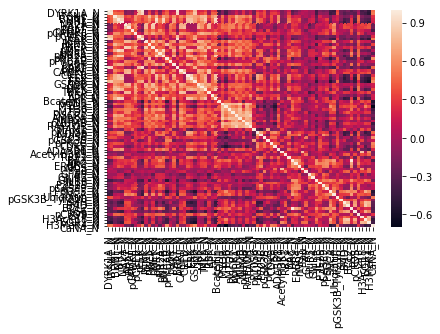

In [9]:
corr = df.corr()
seaborn.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [10]:
mean_by_group = df.groupby(by='class').mean()
std_by_group = df.groupby(by='class').std()

Text(0.5,1,'Средние значения')

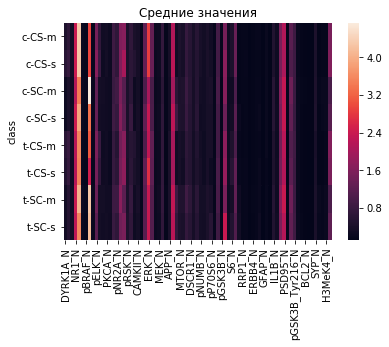

In [11]:
seaborn.heatmap(mean_by_group)
plt.title('Средние значения')

Text(0.5,1,'Вариация')

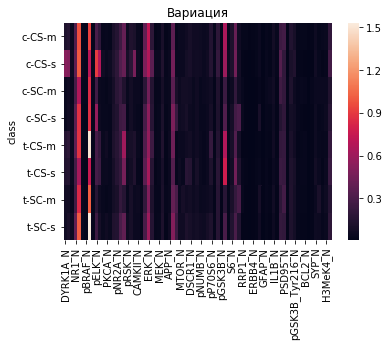

In [12]:
seaborn.heatmap(std_by_group)
plt.title('Вариация')

# 2. Спланировать эксперимент 


Эксперимент - составить план, по которому будет проделана исследовательская работа. Примерные пункты плана:
* Составить первичный список признаков, необходимых для решения задачи
* Сгенерировать список новых признаков, которые можно получить из данных
* Применить понижение размерности для визуализации данных
* Применить кластеризацию, визуализировать
* Описание кластера
* Любые другие пункты

- 1 - заполнить нулевые значения средними по выборке
- 2 - генерировать не будем, их и так много, да и сложно комбинировать экспрессию в генах
- 3 - отмасштабировать призники
- 4 - перевести целевую переменную в категориальную
- 5 - Применить logistic regression с cv на 5 фолдов
- 6 - точность проверям accuracy
- 7 - понижаем размерность  по PCA (до 2 и до оптимального параметра)
- 8 - визуализируем 
- 9 - снова применяем log regression
- 10 - точность проверям accuracy
- 11 - понижаем размерность  по tsne (до 2 и до оптимального параметра)
- 12 - визуализируем 
- 13 - снова применяем log regression
- 14 - точность проверям accuracy
- 15 - ради интереса класстиризуем и визуализируем

# 3. Выполнить подготовку данных для построения модели

Выполнить необходимые преобразования данных

In [13]:
y = df['class']

In [14]:
X = df.drop('class', axis=1)

Удалили целевую переменную и заполняем пустые значения

In [15]:
X.fillna(X.mean(), inplace=True)

In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 77 columns):
DYRK1A_N           1080 non-null float64
ITSN1_N            1080 non-null float64
BDNF_N             1080 non-null float64
NR1_N              1080 non-null float64
NR2A_N             1080 non-null float64
pAKT_N             1080 non-null float64
pBRAF_N            1080 non-null float64
pCAMKII_N          1080 non-null float64
pCREB_N            1080 non-null float64
pELK_N             1080 non-null float64
pERK_N             1080 non-null float64
pJNK_N             1080 non-null float64
PKCA_N             1080 non-null float64
pMEK_N             1080 non-null float64
pNR1_N             1080 non-null float64
pNR2A_N            1080 non-null float64
pNR2B_N            1080 non-null float64
pPKCAB_N           1080 non-null float64
pRSK_N             1080 non-null float64
AKT_N              1080 non-null float64
BRAF_N             1080 non-null float64
CAMKII_N           1080 non-null

In [17]:
from sklearn import preprocessing

выполним масштабирование

In [18]:
scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [19]:
X_scaled[0:1]

array([[0.1511224 , 0.21288505, 0.82463786, 0.61211939, 0.63048232,
        0.32700587, 0.44866634, 0.16825719, 0.61732205, 0.23255279,
        0.15764338, 0.57616682, 0.74768812, 0.59850371, 0.57477459,
        0.28669707, 0.65063705, 0.69816413, 0.62278415, 0.71119844,
        0.13691507, 0.41964854, 0.31714888, 0.59371483, 0.6279069 ,
        0.59626875, 0.64016736, 0.64307006, 0.76614614, 0.29559592,
        0.54981707, 0.74744085, 0.09203489, 0.54119566, 0.15233784,
        0.68726926, 0.55392167, 0.46727792, 0.5099961 , 0.46946126,
        0.4361703 , 0.50601753, 0.16336829, 0.32305865, 0.37325416,
        0.60451592, 0.30336345, 0.17845796, 0.32408545, 0.40280956,
        0.08358366, 0.32786962, 0.69025721, 0.42681623, 0.4127206 ,
        0.47783402, 0.05716795, 0.22882536, 0.53116295, 0.15110301,
        0.24260849, 0.16970155, 0.43284301, 0.48378312, 0.04476956,
        0.25669889, 0.40522832, 0.16294068, 0.17731204, 0.29917191,
        0.42681623, 0.13392994, 0.33629928, 0.08

Еще раз визализируем значения, сейчас должно быть информативнее

In [20]:
df_sc = pd.DataFrame(X_scaled, columns=df.columns[:-1]) 

In [21]:
df_sc['class'] = y

In [22]:
mean_by_group = df_sc.groupby(by='class').mean()
std_by_group = df_sc.groupby(by='class').std()

Text(0.5,1,'Средние значения')

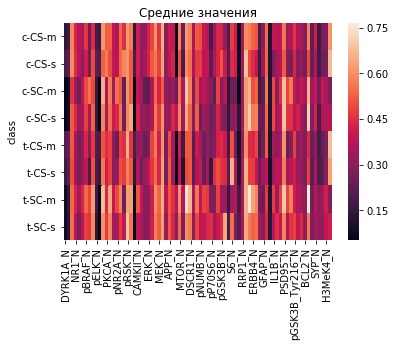

In [23]:
seaborn.heatmap(mean_by_group)
plt.title('Средние значения')

Text(0.5,1,'Вариация')

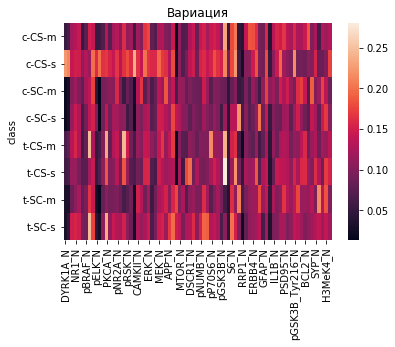

In [24]:
seaborn.heatmap(std_by_group)
plt.title('Вариация')

Как видно, разброс не очень большой. а классы хорошо разделимы.

Теперь y, закодируем его с помощью LabelEncoder

In [25]:
y = y.astype('category')

In [26]:
le = preprocessing.LabelEncoder()

In [27]:
y = le.fit_transform(y)

In [28]:
le.classes_

array(['c-CS-m', 'c-CS-s', 'c-SC-m', 'c-SC-s', 't-CS-m', 't-CS-s',
       't-SC-m', 't-SC-s'], dtype=object)

In [29]:
unique, counts = np.unique(y, return_counts=True)

In [30]:
unique, counts


(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64),
 array([150, 135, 150, 135, 135, 105, 135, 135], dtype=int64))

Классы относительно уравновешены  - их количество очень близко, поэтому дополнительные преобразования не нужны

Text(0.5,1,'Распределение классов')

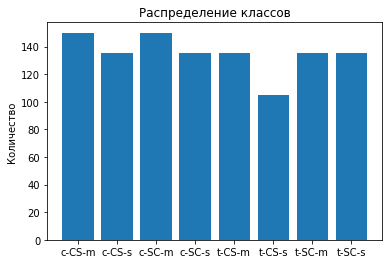

In [31]:
plt.bar(le.classes_, counts)
plt.ylabel('Количество')
plt.title('Распределение классов')

# 4. Провести построение модели 

Сначала обучим LogRegression c 5 CV. И проверим качество на accuarcy

In [32]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)

In [33]:
from sklearn.linear_model import LogisticRegressionCV

In [34]:
lr = LogisticRegressionCV(cv=5)

In [35]:
lr.fit(x_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [36]:
y_predict = lr.predict(x_test)

In [37]:
from sklearn.metrics import accuracy_score


In [38]:
accuracy_score(y_test, y_predict)

0.9938271604938271

Неплохая оценка

In [39]:
lr.coef_.shape

(8, 77)

Text(0.5,1,'Коэффициенты перед экспрессией генов')

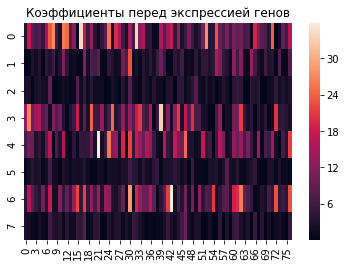

In [40]:
seaborn.heatmap(np.abs(lr.coef_))
plt.title('Коэффициенты перед экспрессией генов')

Заметно, что классы 7, 5, 2, 1 не имеют ярко выраженных определяющих генов.

In [41]:
lr.coef_.mean(axis=0)

array([-1.41193158, -2.65077277,  1.64994993, -0.5117937 ,  2.54959506,
        0.62001776,  1.52495325,  2.86401969, -3.31659144, -1.4262563 ,
       -2.24155073,  0.47011102,  1.15256845,  1.93470685, -0.7709026 ,
       -4.46587192, -3.3244209 , -2.82086949,  0.79588021,  4.01437141,
       -1.25523081, -2.96399271,  1.06887765,  0.31245171, -1.17300008,
       -3.24887149,  3.39854998,  0.10442387,  2.8950723 , -0.60067959,
       -0.15526696, -0.19627595, -2.2501371 ,  0.75926395, -0.8870772 ,
       -2.22698477,  0.69457837, -0.34804193,  0.85100445, -1.02213704,
        0.19691606,  0.61471834, -5.64696322, -3.68427703, -1.10235539,
        1.66576869, -4.01652454,  0.36388559, -3.80747828, -0.11744002,
        2.35965898, -2.24924658, -2.04791695,  0.32633657,  2.52769292,
        2.24961272, -2.00668592, -2.68846056, -0.3509735 , -1.64650697,
        0.01099059,  2.5563939 , -0.96306402,  1.86542268, -1.80924869,
        0.00721195,  2.19622397, -0.14609978,  1.1842486 , -0.93

In [42]:
lr.coef_.max(axis=0)

array([ 6.5528575 , 16.01379663,  9.68671386, 14.24603873, 16.02012624,
       10.33586942, 15.05129237, 17.46137739,  5.65601572,  5.91987167,
        3.23562238, 26.17442756, 24.57104278,  7.29810294, 12.0093683 ,
        7.82597576,  4.89315096, 12.26633332,  5.59327806, 23.96359465,
        6.16308356, 14.57609791, 13.73505177,  8.24836362, 25.21566618,
        3.22077253, 19.45402662,  4.92114456, 19.18758867,  7.194866  ,
       28.42753555,  7.53245797, 19.08188707, 20.96627013,  9.32063959,
        9.68401222, 16.27288855,  5.44428612,  5.68826831, 15.41086691,
        8.11521069, 21.25862131,  3.15051308,  4.33248784, 11.29016914,
        9.81600669, 10.27590226, 10.74259548,  5.52566406,  6.60329832,
       13.14602982, 10.32750333,  7.4441891 ,  6.66297976, 20.79088139,
       22.71184587, 12.68712792,  4.84867425, 10.81223575,  1.68502149,
       13.11627419, 10.72904205, 26.09035187,  9.51413304,  7.25554247,
        5.38095408, 19.01226984, 11.22904797,  8.14420842,  6.89

In [43]:
np.abs(lr.coef_).min(axis=0)

array([0.06499749, 0.45171417, 0.44813822, 0.64545964, 2.19199195,
       0.08368474, 0.60481608, 1.64012203, 0.08107475, 0.47269143,
       0.41510826, 0.95547038, 0.49510166, 0.57370799, 0.97750979,
       0.62036323, 0.14434786, 3.4010924 , 0.05659607, 0.00462526,
       0.26150781, 1.39145337, 0.10851228, 0.0949691 , 0.62241508,
       1.5907261 , 1.31129433, 0.46029771, 0.94806225, 0.3024998 ,
       1.36686055, 0.89726516, 1.52074716, 0.2887654 , 1.09267969,
       0.04656206, 0.63882146, 0.28217044, 0.72781357, 0.64977727,
       0.35175628, 0.37472472, 0.49319118, 0.18784952, 2.87347853,
       1.51400079, 0.75166928, 0.28598928, 1.03246019, 1.05251305,
       1.04367202, 0.08874923, 0.46274015, 0.45261052, 0.2141315 ,
       0.10184516, 1.16303534, 0.07048105, 1.60169573, 0.12878807,
       1.79469077, 3.4182804 , 0.71345155, 0.53371288, 0.26050816,
       0.10675796, 0.00999025, 0.3581716 , 0.41352019, 0.26098609,
       0.45261052, 0.2555217 , 0.01598044, 0.1203163 , 0.60459

Чисто визуально, коэффициенты НЕ занижены, что говорит, что в предсказании участвуют все гены. Для более детального анализа построим графики 

Немного украдем кода из лекции:

In [44]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x_train)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

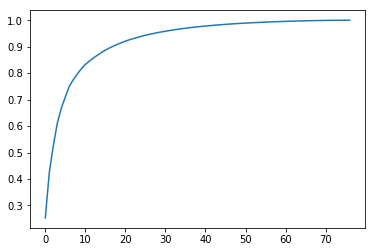

In [45]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum)

Возьмем первые 20, что грубо обеспечивает 90% дисперсии

In [46]:
pca = PCA(n_components=20)
x_train_pca = pca.fit_transform(x_train)

In [47]:
lr = LogisticRegressionCV(cv=5)
lr.fit(x_train_pca, y_train)
y_pred20 = lr.predict(pca.transform(x_test))
accuracy_score(y_test, y_pred20)

0.9135802469135802

Упало, но не намного. Повторим для n=2, чтобы визуализировать

In [48]:
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train)
lr = LogisticRegressionCV(cv=5)
lr.fit(x_train_pca, y_train)
y_pred = lr.predict(pca.transform(x_test))
accuracy_score(y_test, y_pred)

0.3148148148148148

Как видно, точно очень плохая. Попробуем визуализировать

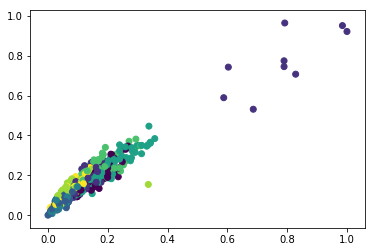

In [49]:
plt.scatter(x_train[:,0], x_train[:,1], c=y_train)

Не очень четко

Теперь повторим в from sklearn.manifold import TSNE

In [50]:
from sklearn.manifold import TSNE

Text(0.5,1,'Попытка разграничение с TSNE. Классы истинные, perplexity = 30')

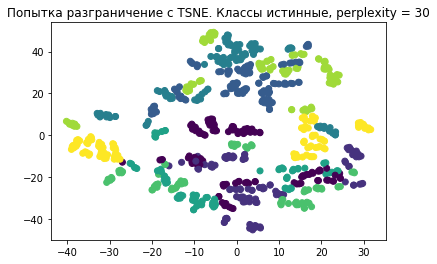

In [51]:
tsne = TSNE(n_components=2)
x_train_tsne = tsne.fit_transform(x_train)
plt.scatter(x_train_tsne[:,0], x_train_tsne[:,1], c=y_train)
plt.title('Попытка разграничение с TSNE. Классы истинные, perplexity = 30')

Text(0.5,1,'Попытка разграничение с TSNE. Классы истинные, perplexity = 5')

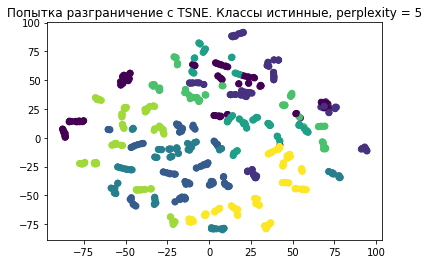

In [52]:
tsne = TSNE(n_components=2, perplexity = 5)
x_train_tsne = tsne.fit_transform(x_train)
plt.scatter(x_train_tsne[:,0], x_train_tsne[:,1], c=y_train)
plt.title('Попытка разграничение с TSNE. Классы истинные, perplexity = 5')

In [ ]:
tsne = TSNE(n_components=2, perplexity = 50, )
x_train_tsne = tsne.fit_transform(x_train)
plt.scatter(x_train_tsne[:,0], x_train_tsne[:,1], c=y_train)
plt.title('Попытка разграничение с TSNE. Классы истинные, perplexity = 50')

In [ ]:
tsne = TSNE(n_components=2, perplexity = 50, learning_rate =500)
x_train_tsne = tsne.fit_transform(x_train)
plt.scatter(x_train_tsne[:,0], x_train_tsne[:,1], c=y_train)
plt.title('Попытка разграничение с TSNE. Классы истинные, perplexity = 50, learning_rate =500')

Попробуем выполнить кластеризацию и визиализируем ее на tsne

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
sc = DBSCAN(eps = 0.6)

In [ ]:
y_dbscan = sc.fit_predict(x_train)

In [ ]:

plt.scatter(x_train_tsne[:,0], x_train_tsne[:,1], c=y_dbscan)
plt.title('Попытка разграничение с TSNE. DBSCAN, perplexity = 50, learning_rate =500')

# 5. Проанализировать результат
получилось или нет, почему, что можно улучшить, можно ли интерпретировать результат

Что получилось: 
    - подготовить признаки для логистической регрессии
    - уменьшить количество признаков без значимого падения точности
    - неплохая попытка визуализации с помощью TSNE
Что не получилось:
    - точное разделение при 2 мерной проекции. 
    хотя скорее всего этого добиться сложно, 
    так как много классов и как было отмечено 
    при анализе логистической регрессии значимость признаков довольно близка
    - классификация - что в принципе и ожидалось,
    так как сложно подобрать оптимальные параметры. 

Попробуем kmeans)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
km = KMeans(n_clusters=8)

In [ ]:
y_km = km.fit_predict(x_train)

In [ ]:

plt.scatter(x_train_tsne[:,0], x_train_tsne[:,1], c=y_km)
plt.title('Попытка разграничение с TSNE. KMeans, perplexity = 50, learning_rate =500')

Попытка не очень удачная, зато визуализация очень хорошая)